In [1]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from time import time
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [41]:
def nms(heat, kernel=3):
    hmax = tf.keras.layers.MaxPool2D(pool_size=kernel, strides=1, padding='same')(heat)
    heat = tf.where(tf.equal(hmax, heat), heat, tf.zeros_like(heat))
    return heat

def topk(hm, max_objects=100):
    hm = nms(hm)
    # (b, h * w * c)
    b, h, w, c = tf.shape(hm)[0], tf.shape(hm)[1], tf.shape(hm)[2], tf.shape(hm)[3]
    hm = tf.reshape(hm, (b, -1))
    # (b, k), (b, k)
    scores, indices = tf.nn.top_k(hm, k=max_objects)
    class_ids = indices % c
    xs = indices // c % w
    ys = indices // c // w
    indices = ys * w + xs
    return scores, indices, class_ids, xs, ys

def _multi_range(limit,
                 value_repetitions=1,
                 range_repetitions=1,
                 dtype=tf.int32):
  """Creates a sequence with optional value duplication and range repetition.

  As an example (see the Args section for more details),
  _multi_range(limit=2, value_repetitions=3, range_repetitions=4) returns:

  [0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1]
  """
  return tf.reshape(
      tf.tile(
          tf.expand_dims(tf.range(limit, dtype=dtype), axis=-1),
          multiples=[range_repetitions, value_repetitions]), [-1])

def prediction_tensors_to_boxes(y_indices, x_indices, height_width_predictions,
                                offset_predictions):
    """Converts CenterNet class-center, offset and size predictions to boxes.

    Args:
    y_indices: A [batch, num_boxes] int32 tensor with y indices corresponding to
      object center locations (expressed in output coordinate frame).
    x_indices: A [batch, num_boxes] int32 tensor with x indices corresponding to
      object center locations (expressed in output coordinate frame).
    height_width_predictions: A float tensor of shape [batch_size, height,
      width, 2] representing the height and width of a box centered at each
      pixel.
    offset_predictions: A float tensor of shape [batch_size, height, width, 2]
      representing the y and x offsets of a box centered at each pixel. This
      helps reduce the error from downsampling.

    Returns:
    detection_boxes: A tensor of shape [batch_size, num_boxes, 4] holding the
      the raw bounding box coordinates of boxes.
    """
    batch_size, num_boxes = tf.shape(y_indices)
    _, height, width, _ = tf.shape(height_width_predictions)
    height, width = tf.cast(height, tf.float32), tf.cast(width, tf.float32)

    # TF Lite does not support tf.gather with batch_dims > 0, so we need to use
    # tf_gather_nd instead and here we prepare the indices for that.
    combined_indices = tf.stack([
      _multi_range(batch_size, value_repetitions=num_boxes),
      tf.reshape(y_indices, [-1]),
      tf.reshape(x_indices, [-1])
    ], axis=1)
    new_height_width = tf.gather_nd(height_width_predictions, combined_indices)
    new_height_width = tf.reshape(new_height_width, [batch_size, num_boxes, 2])

    new_offsets = tf.gather_nd(offset_predictions, combined_indices)
    offsets = tf.reshape(new_offsets, [batch_size, num_boxes, 2])

    y_indices = tf.cast(y_indices, dtype=tf.float32)
    x_indices = tf.cast(x_indices, dtype=tf.float32)

    height_width = tf.maximum(new_height_width, 0)
#     heights, widths = tf.unstack(height_width, axis=2)
#     y_offsets, x_offsets = tf.unstack(offsets, axis=2)
    widths, heights = tf.unstack(height_width, axis=2)
    x_offsets, y_offsets = tf.unstack(offsets, axis=2)

    ymin = y_indices + y_offsets - heights / 2.0 
    xmin = x_indices + x_offsets - widths / 2.0 
    ymax = y_indices + y_offsets + heights / 2.0 
    xmax = x_indices + x_offsets + widths / 2.0 

    ymin = tf.clip_by_value(ymin, 0., height)
    xmin = tf.clip_by_value(xmin, 0., width)
    ymax = tf.clip_by_value(ymax, 0., height)
    xmax = tf.clip_by_value(xmax, 0., width)
    xmin, ymin, xmax, ymax = xmin/width, ymin/height, xmax/width, ymax/height

    boxes = tf.stack([xmin, ymin, xmax, ymax], axis=2)

    return boxes

def decode(hm, wh, reg, max_objects=100):
    scores, indices, class_ids, xs, ys = topk(hm, max_objects=max_objects)
    boxes = prediction_tensors_to_boxes(ys, xs, wh, reg)
    scores = tf.expand_dims(scores, axis=-1)
    class_ids = tf.cast(tf.expand_dims(class_ids, axis=-1), tf.float32)
    return tf.concat([boxes, scores, class_ids], -1, name='concat_last')

def decode2(hm, wh, reg, max_objects=100):
    scores, indices, class_ids, xs, ys = topk(hm, max_objects=max_objects)
    b = tf.shape(hm)[0]
    h = tf.cast(tf.shape(hm)[1], tf.float32)
    w = tf.cast(tf.shape(hm)[2], tf.float32)
    # (b, h * w, 2)
    reg = tf.reshape(reg, (b, -1, tf.shape(reg)[-1]))
    # (b, h * w, 2)
    wh = tf.reshape(wh, (b, -1, tf.shape(wh)[-1]))
    # (b, k, 2)
    topk_reg = tf.gather(reg, indices, batch_dims=1)
    # (b, k, 2)
    topk_wh = tf.cast(tf.gather(wh, indices, batch_dims=1), tf.float32)
    topk_cx = tf.cast(tf.expand_dims(xs, axis=-1), tf.float32) + topk_reg[..., 0:1]
    topk_cy = tf.cast(tf.expand_dims(ys, axis=-1), tf.float32) + topk_reg[..., 1:2]
    scores = tf.expand_dims(scores, axis=-1)
    class_ids = tf.cast(tf.expand_dims(class_ids, axis=-1), tf.float32)
    topk_x1 = topk_cx - topk_wh[..., 0:1] / 2
    topk_x2 = topk_cx + topk_wh[..., 0:1] / 2
    topk_y1 = topk_cy - topk_wh[..., 1:2] / 2
    topk_y2 = topk_cy + topk_wh[..., 1:2] / 2
    
    ## scale to (0, 1):
    topk_x1, topk_x2, topk_y1, topk_y2 = topk_x1/w, topk_x2/w, topk_y1/h, topk_y2/h
    # (b, k, 6)
    detections = tf.concat([topk_x1, topk_y1, topk_x2, topk_y2, scores, class_ids], axis=-1)
    return detections

In [ ]:
json_path = 'trained_models/voc_resnet_fpn_silu_centernet/model.json'
h5_path = 'trained_models/voc_resnet_fpn_silu_centernet/weights_43_3.8134.h5'

with open(json_path, 'r') as f:
    model = tf.keras.models.model_from_json(f.read())
model.load_weights(h5_path)

# model = tf.saved_model.load('trained_models/polyp_20220623/savedmodel')

In [ ]:
##Export to savemodel
root = 'trained_models/polyp_resnet_fpn_20220807'
json_path = os.path.join(root, 'model.json')
h5_path = os.path.join(root, 'weights_10_2.1058.h5')

with open(json_path, 'r') as f:
    model = tf.keras.models.model_from_json(f.read())
model.load_weights(h5_path)
out = model.output
detections = decode(out[..., 4:], out[..., :2], out[..., 2:4], 10)
model_infer = tf.keras.Model(inputs=model.input, outputs=detections)
model_infer.summary()
model_infer.save(os.path.join(root, 'savedmodel'))

model = tf.saved_model.load(os.path.join(root, 'savedmodel'))

In [35]:
def preprocess_image(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image.astype(np.float32)

#     image[..., 0] -= 103.939
#     image[..., 1] -= 116.779
#     image[..., 2] -= 123.68

    return image / 255.0

def resize(size, image):
    h, w, c = image.shape
    scale_w = size / w
    scale_h = size / h
    scale = min(scale_w, scale_h)
    h = int(h * scale)
    w = int(w * scale)
    padimg = np.zeros((size, size, c), image.dtype)
    padimg[:h, :w] = cv2.resize(image, (w, h))
    return padimg

def inv_resize(src_size, image):
    h, w = src_size
    h_cs, w_cs = image.shape[:2]
    scale_h = h_cs / h
    scale_w = w_cs / w
    scale = min(scale_w, scale_h)
    h_new = int(h * scale)
    w_new = int(w * scale)
    img = image[:h_new, :w_new]
    img = cv2.resize(img, (w, h))
    return img

def rescale_boxes(size, im_shape, boxes):
    w, h = im_shape
    scale_w = size / w
    scale_h = size / h
    scale = min(scale_w, scale_h)
    new_anns = []
    for box in boxes:
        xmin, ymin, xmax, ymax = [int(p/scale) for p in box]
        new_anns.append([xmin, ymin, xmax, ymax])
    return np.array(new_anns)
        

def get_listnames(root, part='train'):
    with open(os.path.join(root, 'ImageSets', 'Main', part+'.txt'), 'r') as f:
        names = f.read().split('\n')
    names = [name + '.jpg' for name in names if name != '']
    return names

import xml.etree.ElementTree as ET 
def parse_xml(xml):
    root = ET.parse(xml).getroot()
    objs = root.findall('object')
    boxes, ymins, obj_names = [], [], []
    for obj in objs:
        obj_name = obj.find('name').text
        box = obj.find('bndbox')
        xmin = float(box.find('xmin').text)
        ymin = float(box.find('ymin').text)
        xmax = float(box.find('xmax').text)
        ymax = float(box.find('ymax').text)
        ymins.append(ymin)
#         boxes.append([[xmin, ymin], [xmax, ymin],
#                       [xmax, ymax], [xmin, ymax]])
        boxes.append([xmin, ymin, xmax, ymax])
        obj_names.append(obj_name)
    indices = np.argsort(ymins)
    boxes = [boxes[i] for i in indices]
    obj_names = [obj_names[i] for i in indices]
    return np.array(boxes, dtype=np.float), obj_names

def viz_heatmap(hm):
    hm_max = np.max(hm, 2)
    heatmap = cv2.applyColorMap((hm_max*255).astype('uint8'), cv2.COLORMAP_JET)
    return heatmap

In [ ]:
import json
root = '/data2/sonnh/E2EObjectDetection/VOC2012'
names = get_listnames(root, part='train')
# names = [os.path.join(root, 'JPEGImages', name) for name in names]

with open('config/classes_voc.json', 'r') as f:
    classes_dict = json.load(f)
classes = list(classes_dict.keys())
num_classes = len(classes)
score_threshold = 0.2
colors = [np.random.randint(0, 256, 3).tolist() for i in range(num_classes)]

for name in names:
    fp = os.path.join(root, 'JPEGImages', name)
    image = cv2.imread(fp)
    src_image = image.copy()
    h, w = src_image.shape[:2]
    image = resize(512, image)
#     image = cv2.resize(image, (512, 512))
    image = preprocess_image(image)
    inputs = np.expand_dims(image, axis=0)
    # run network
    start = time()
    out = model(inputs)
#     print(outputs.shape)
#     hm, wh, reg = outputs[0], outputs[1], outputs[2]
    detections = decode2(out[..., 4:], out[..., :2], out[..., 2:4], 10)[0].numpy()
    print(detections)
    print(time() - start)
    scores = detections[:, 4]
    # select indices which have a score above the threshold
    indices = np.where(scores > score_threshold)[0]

    # select those detections
    detections = detections[indices]
    detections = detections.astype(np.float64)

#     detections[:, [0, 2]] = np.clip(detections[:, [0, 2]], 0, src_image.shape[1])
#     detections[:, [1, 3]] = np.clip(detections[:, [1, 3]], 0, src_image.shape[0])
    boxes, scores, class_ids = detections[..., :4], detections[..., 4], detections[..., 5]
    boxes = boxes * 512
    boxes = rescale_boxes(512, (w, h), boxes)
    for box, score, class_id in zip(boxes, scores, class_ids):
        xmin, ymin, xmax, ymax = box
#         xmin, ymin = int(xmin*w), int(ymin*h)
#         xmax, ymax = int(xmax*w), int(ymax*h) 
        print(xmin, ymin, xmax, ymax)
        score = '{:.4f}'.format(score)
        class_id = int(class_id)
        color = colors[class_id]
        class_name = classes[class_id]
        label = '-'.join([class_name, score])
        ret, baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
        cv2.rectangle(src_image, (xmin, ymin), (xmax, ymax), color, 1)
        cv2.rectangle(src_image, (xmin, ymax - ret[1] - baseline), (xmin + ret[0], ymax), color, -1)
        cv2.putText(src_image, label, (xmin, ymax - baseline), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)
        
#     heatmap = cv2.resize(resize(512, viz_heatmap(out[..., 4:][0])), (w, h))
    heatmap = inv_resize((h, w), cv2.resize(viz_heatmap(out[..., 4:][0]), (512, 512)))
    src_image = cv2.addWeighted(src_image, 0.7, heatmap, 0.3, 0)
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(src_image, cv2.COLOR_BGR2RGB))
#     plt.figure(figsize=(10,10))
#     plt.imshow(viz_heatmap(out[..., 4:][0]))
    plt.show()
    input()


## Test for polyp dataset

In [21]:
## Load data

root = '/data2/sonnh/E2EObjectDetection/PolypsSet_origin/test2019'
test_data = []
for sub in os.listdir(os.path.join(root, 'Image')):
    for name in os.listdir(os.path.join(root, 'Image', sub))[::50]:
        fp = os.path.join(root, 'Image', sub, name)
        lp = os.path.join(root, 'Annotation', sub, name[:-3] + 'xml')
        if not os.path.exists(fp):
            print('khong co anh')
            continue

        if not os.path.exists(lp):
            print('khong co nhan')
            continue

        test_data.append({'im_path':fp, 'lb_path':lp})


print(len(test_data))



109


In [31]:
model = tf.saved_model.load('trained_models/20220929/savedmodel')

In [47]:
import json

classes = ["adenomatous", "hyperplastic"]
num_classes = len(classes)
score_threshold = 0.2
colors = [np.random.randint(0, 256, 3).tolist() for i in range(num_classes)]
save = False
view = True
input_size = 512

for d in test_data:
    fp, lp = d['im_path'], d['lb_path']
    print(fp)
    image = cv2.imread(fp)
    src_image = image.copy()
    src_image_2 = image.copy()
    image = resize(input_size, image)
#     image = cv2.resize(image, (640, 640))
    image = preprocess_image(image)
    inputs = np.expand_dims(image, axis=0)
    # run network
    start = time()
    detections = model(inputs, training=False)[0].numpy()
    print(time() - start)
    h, w = src_image.shape[:2]
    boxes, scores, class_ids = detections[..., :4], detections[..., 4], detections[..., 5]
    if save:
        imname = fp.split('/')[-1]
        subname = fp.split('/')[-2]
        savepath = os.path.join('/data2/sonnh/E2EObjectDetection/PolypsSet/result_test_tfodapi',subname)
        if not os.path.exists(savepath):
            os.makedirs(savepath)
        to_xml(os.path.join(savepath, imname[:-3]+'jpg'), imname, boxes, classes, (h, w))
    boxes = boxes * input_size
    boxes = rescale_boxes(input_size, (w, h), boxes)
#     print(boxes, scores, class_ids)
    for box, score, class_id in zip(boxes, scores, class_ids):
        if score < score_threshold:
            continue
        xmin, ymin, xmax, ymax = box
#         xmin, ymin, xmax, ymax = int(xmin*w), int(ymin*h), int(xmax*w), int(ymax*h)

        xc, yc = (xmin + xmax) // 2, (ymin + ymax) // 2
        print(xmin, ymin, xmax, ymax, class_id, score)
        score = '{:.4f}'.format(score)
        class_id = int(class_id)
        color = colors[class_id]
        class_name = classes[class_id]
        label = '-'.join([class_name, score])
        ret, baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
        cv2.circle(src_image, (xc, yc), 5, color, -1)
        cv2.rectangle(src_image, (xmin, ymin), (xmax, ymax), color, 1)
        cv2.rectangle(src_image, (xmin, ymax - ret[1] - baseline), (xmin + ret[0], ymax), color, -1)
        cv2.putText(src_image, label, (xmin, ymax - baseline), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)
    ## Draw label 
    lb_boxes, lb_names = parse_xml(lp)
    for box, class_name in zip(lb_boxes, lb_names):
        xmin, ymin, xmax, ymax = box[:4]
        xmin = int(xmin)
        ymin = int(ymin)
        xmax = int(xmax) 
        ymax = int(ymax) 
#         print(xmin, ymin, xmax, ymax)
        class_id = classes.index(class_name)
        color = colors[class_id]
        label = '-'.join([class_name])
        ret, baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
        cv2.rectangle(src_image_2, (xmin, ymin), (xmax, ymax), color, 1)
        cv2.rectangle(src_image_2, (xmin, ymax - ret[1] - baseline), (xmin + ret[0], ymax), color, -1)
        cv2.putText(src_image_2, label, (xmin, ymax - baseline), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)
    
#     heatmap = inv_resize((h, w), cv2.resize(viz_heatmap(out[..., 4:][0]), (512, 512)))
#     src_image_2 = cv2.addWeighted(src_image_2, 0.7, heatmap, 0.3, 0)
    src_image = np.concatenate([src_image, src_image_2], 1)
    plt.figure(figsize=(15, 15))
    plt.imshow(cv2.cvtColor(src_image, cv2.COLOR_BGR2RGB))
#     plt.figure(figsize=(10,10))
#     plt.imshow(heatmap)
    plt.show()
    input()


/data2/sonnh/E2EObjectDetection/PolypsSet_origin/test2019/Image/18/8.jpg


ValueError: Could not find matching function to call loaded from the SavedModel. Got:
  Positional arguments (3 total):
    * Tensor("inputs:0", shape=(1, 640, 640, 3), dtype=float32)
    * False
    * None
  Keyword arguments: {}

Expected these arguments to match one of the following 4 option(s):

Option 1:
  Positional arguments (3 total):
    * TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name='inputs')
    * True
    * None
  Keyword arguments: {}

Option 2:
  Positional arguments (3 total):
    * TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name='input_1')
    * True
    * None
  Keyword arguments: {}

Option 3:
  Positional arguments (3 total):
    * TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name='inputs')
    * False
    * None
  Keyword arguments: {}

Option 4:
  Positional arguments (3 total):
    * TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name='input_1')
    * False
    * None
  Keyword arguments: {}

In [46]:
### Visualize heatmap label
import json
with open('config/classes_polyp.json', 'r') as f:
    classes_dict = json.load(f)
classes = list(classes_dict.keys())
num_classes = len(classes)
colors = [np.random.randint(0, 256, 3).tolist() for i in range(num_classes)]
from config.polyp_hparams import hparams
from generators.dataset_custom import get_polyp_test_generator
# train_gen, val_gen = get_polyp_generator(hparams)
test_gen = get_polyp_test_generator(hparams)
# print(len(train_gen), len(val_gen))
for i, d in enumerate(test_gen):
    images, hms, whs, regs = d[0], d[1][..., 4:], d[1][..., :2], d[1][..., 2:4]
    for image, hm, wh, reg in zip(images, hms, whs, regs):
        image = train_gen.reverse_preprocess(image)
        decodes = decode2(np.expand_dims(hm, 0),
                         np.expand_dims(wh, 0),
                         np.expand_dims(reg, 0), 10)[0].numpy()
        # select indices which have a score above the threshold
        indices = np.where(decodes[:, 4] == 1.0)
        # select those detections
        decodes = decodes[indices]
        decodes = decodes.astype(np.float32)
        h, w = image.shape[:2]
        boxes, scores, class_ids = decodes[..., :4], decodes[..., 4], decodes[..., 5]
        print(boxes)
#         boxes = boxes * 512
#         boxes = rescale_boxes(512, (w, h), boxes)
        for box, score, class_id in zip(boxes, scores, class_ids):
            xmin, ymin, xmax, ymax = box
            xc, yc = (xmin + xmax) // 2, (ymin + ymax) // 2
    #         xmin, ymin, xmax, ymax = int(xmin/128*w), int(ymin/128*h), int(xmax/128*w), int(ymax/128*h)
            print(xmin, ymin, xmax, ymax)
            score = '{:.4f}'.format(score)
            class_id = int(class_id)
            color = colors[class_id]
            class_name = classes[class_id]
            label = '-'.join([class_name, score])
            ret, baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
            image = cv2.circle(image, (xc, yc), 5, color, -1)
            image = cv2.rectangle(image, (xmin, ymin), (xmax, ymax), color, 1)
            image = cv2.rectangle(image, (xmin, ymax - ret[1] - baseline), (xmin + ret[0], ymax), color, -1)
            image = cv2.putText(image, label, (xmin, ymax - baseline), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)
        hm = viz_heatmap(hm)
        heatmap = inv_resize((h, w), cv2.resize(hm, (512, 512)))
        image = cv2.addWeighted(image, 0.7, heatmap, 0.3, 0)
        plt.figure(figsize=(10, 10))
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.show()
        input()

[[0.3671875 0.34375   0.3671875 0.34375  ]]
0.3671875 0.34375 0.3671875 0.34375


TypeError: integer argument expected, got float

In [3]:
#Test augmentation
from augmentor.color import VisualEffect
from augmentor.misc import MiscEffect

/data2/sonnh/E2EObjectDetection/PolypsSet_origin/test2019/Image/18/8.jpg
[[165. 161. 261. 235.]] ['hyperplastic']
[[201  83 278 142]] ['hyperplastic']
201 83 278 142 1


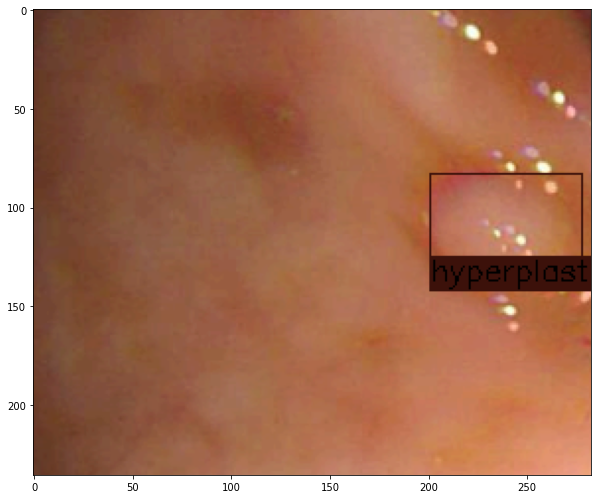


/data2/sonnh/E2EObjectDetection/PolypsSet_origin/test2019/Image/16/75.jpg
[[431. 169. 556. 289.]] ['adenomatous']
[[212 100 312 196]] ['adenomatous']
212 100 312 196 0


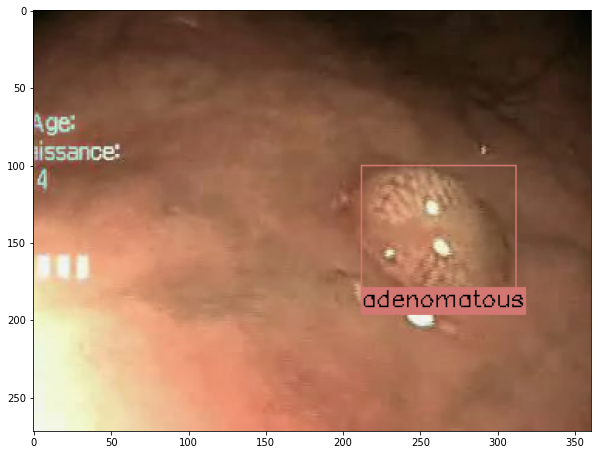


/data2/sonnh/E2EObjectDetection/PolypsSet_origin/test2019/Image/16/103.jpg
[[390. 221. 502. 330.]] ['adenomatous']
[[152.79062188  77.71024517 253.79062188 175.71024517]] ['adenomatous']
152 77 253 175 0


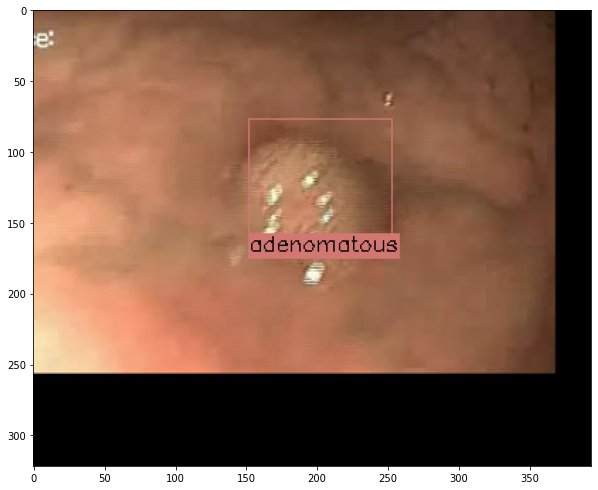


/data2/sonnh/E2EObjectDetection/PolypsSet_origin/test2019/Image/16/168.jpg
[[517. 249. 582. 326.]] ['adenomatous']
[[517. 249. 582. 326.]] ['adenomatous']
517 249 582 326 0


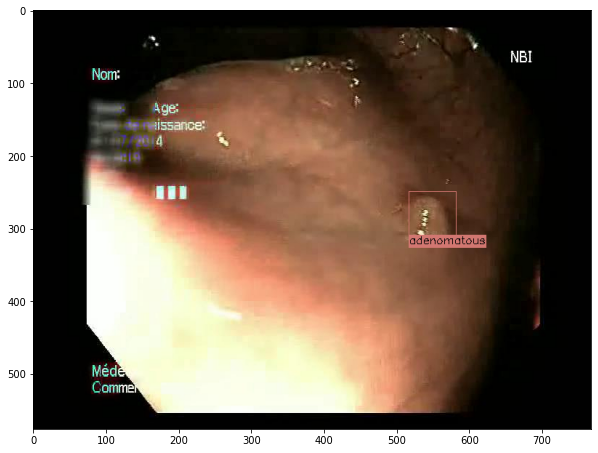


/data2/sonnh/E2EObjectDetection/PolypsSet_origin/test2019/Image/16/140.jpg
[[410. 397. 498. 485.]] ['adenomatous']
[[ 70.38420741 202.82657019 158.38420741 290.82657019]] ['adenomatous']
70 202 158 290 0


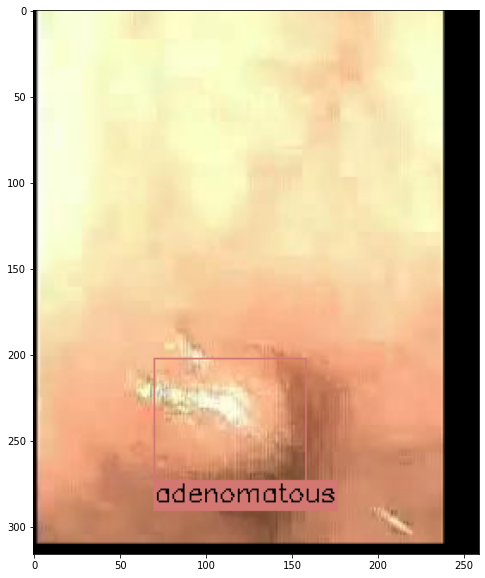


/data2/sonnh/E2EObjectDetection/PolypsSet_origin/test2019/Image/4/239.jpg
[[176. 210. 458. 442.]] ['hyperplastic']
[[102.74438751  39.75967685 311.74438751 293.75967685]] ['hyperplastic']
102 39 311 293 1


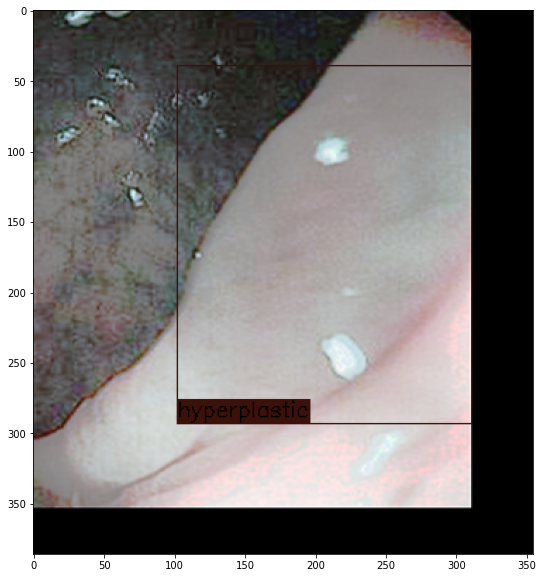


/data2/sonnh/E2EObjectDetection/PolypsSet_origin/test2019/Image/4/432.jpg
[[243. 230. 477. 425.]] ['hyperplastic']
[[ 98.5 135.5 235.5 299.5]] ['hyperplastic']
98 135 235 299 1


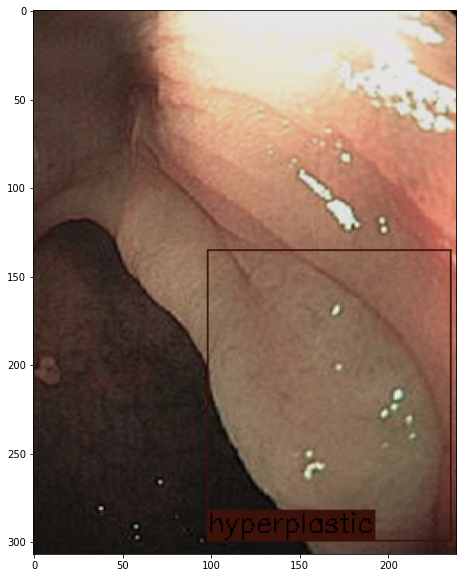


/data2/sonnh/E2EObjectDetection/PolypsSet_origin/test2019/Image/4/311.jpg
[[144. 252. 414. 437.]] ['hyperplastic']
[[ 11. 144. 196. 414.]] ['hyperplastic']
11 144 196 414 1


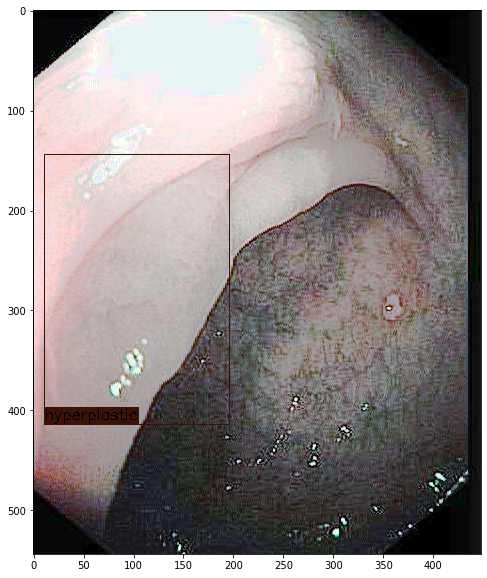


/data2/sonnh/E2EObjectDetection/PolypsSet_origin/test2019/Image/4/126.jpg
[[246. 341. 408. 448.]] ['hyperplastic']
[[  2.47509801 150.2431213  141.47509801 360.2431213 ]] ['hyperplastic']
2 150 141 360 1


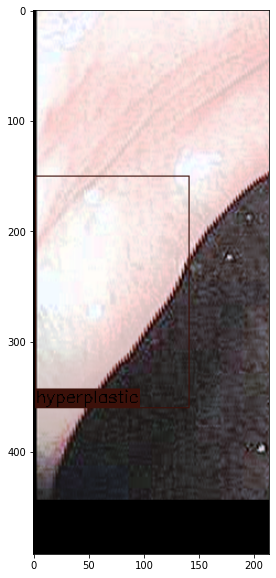


/data2/sonnh/E2EObjectDetection/PolypsSet_origin/test2019/Image/4/67.jpg
[[206. 285. 350. 409.]] ['hyperplastic']
[[110.  30. 225. 129.]] ['hyperplastic']
110 29 225 128 1


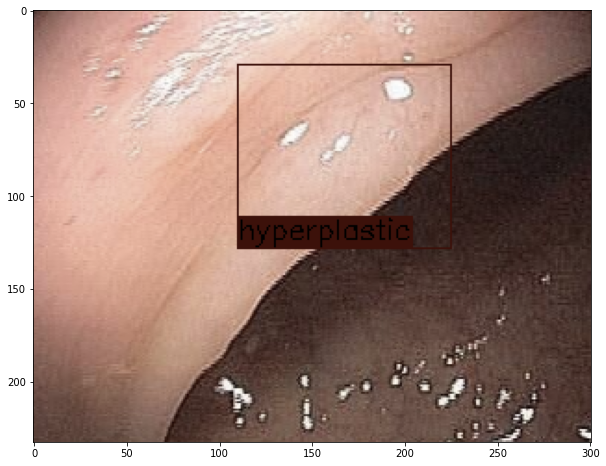


/data2/sonnh/E2EObjectDetection/PolypsSet_origin/test2019/Image/4/153.jpg
[[244. 253. 406. 396.]] ['hyperplastic']
[[117.  37. 296. 195.]] ['hyperplastic']
117 37 296 195 1


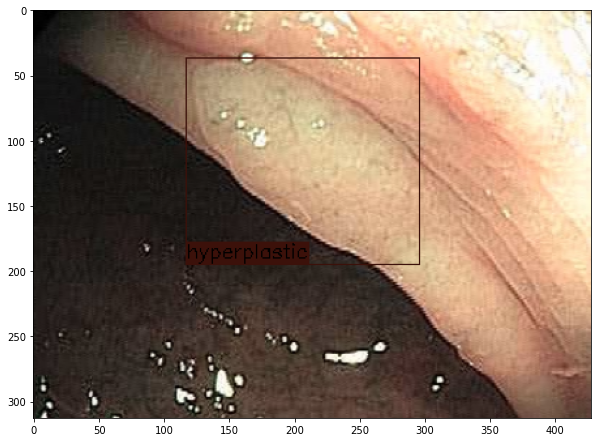


/data2/sonnh/E2EObjectDetection/PolypsSet_origin/test2019/Image/4/394.jpg
[[253. 232. 469. 427.]] ['hyperplastic']
[[203. 192. 419. 387.]] ['hyperplastic']
203 192 419 387 1


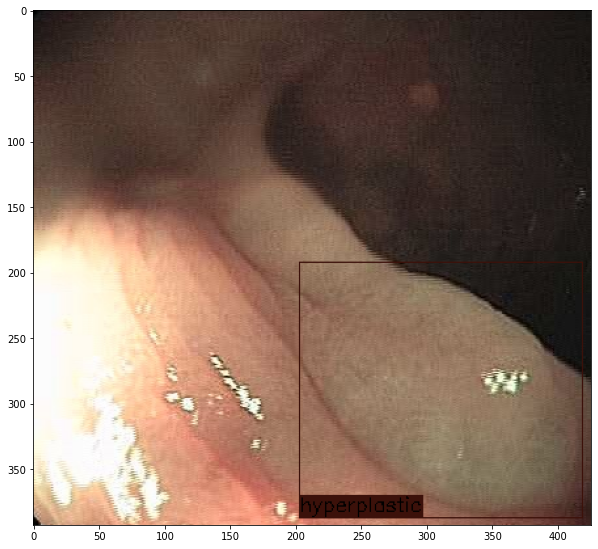


/data2/sonnh/E2EObjectDetection/PolypsSet_origin/test2019/Image/4/132.jpg
[[249. 270. 411. 407.]] ['hyperplastic']
[[146. 152. 283. 314.]] ['hyperplastic']
146 152 283 314 1


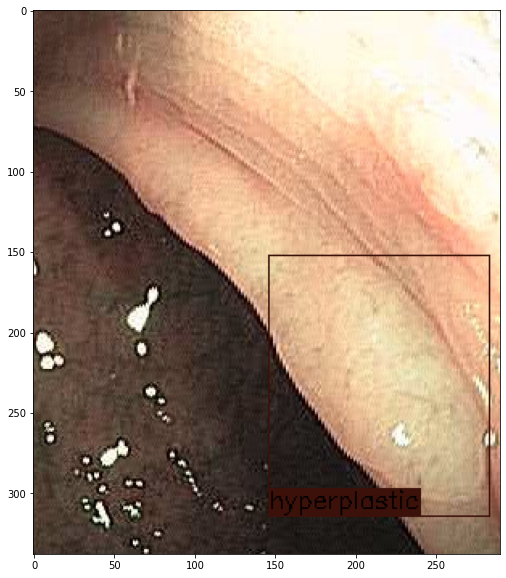


/data2/sonnh/E2EObjectDetection/PolypsSet_origin/test2019/Image/4/93.jpg
[[242. 260. 338. 348.]] ['hyperplastic']
[[260.68688516 117.70965521 356.68688516 205.70965521]] ['hyperplastic']
260 117 356 205 1


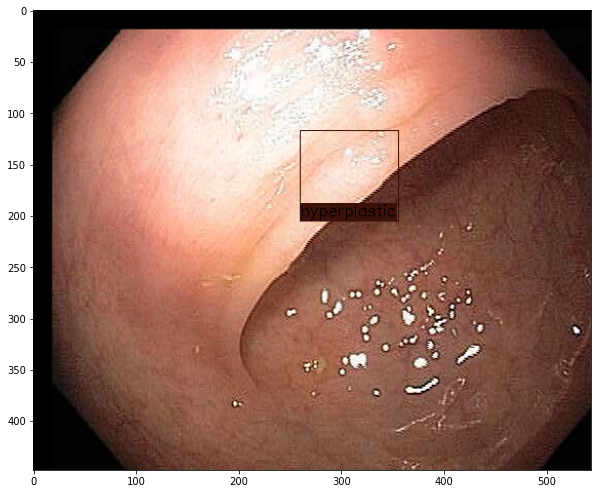


/data2/sonnh/E2EObjectDetection/PolypsSet_origin/test2019/Image/4/370.jpg
[[187. 270. 439. 448.]] ['hyperplastic']
[[ 31.75751047  66.02844331 245.75751047 369.02844331]] ['hyperplastic']
31 66 245 369 1


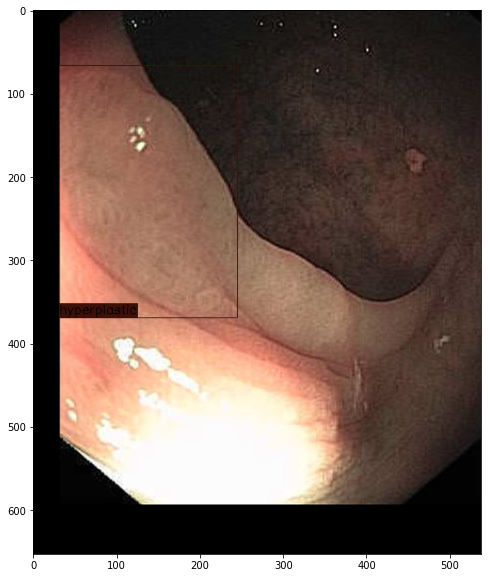


/data2/sonnh/E2EObjectDetection/PolypsSet_origin/test2019/Image/12/75.jpg
[[190. 128. 221. 154.]] ['hyperplastic']
[[213.43673985 185.32708298 244.43673985 211.32708298]] ['hyperplastic']
213 185 244 211 1


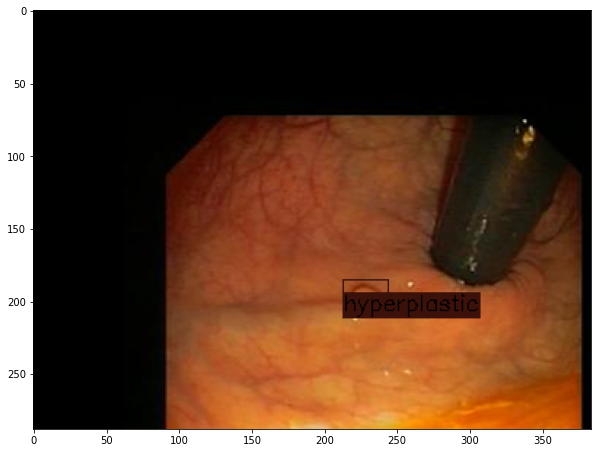


/data2/sonnh/E2EObjectDetection/PolypsSet_origin/test2019/Image/12/138.jpg
[[147.  87. 197. 133.]] ['hyperplastic']
[[147.  87. 197. 133.]] ['hyperplastic']
147 87 197 133 1


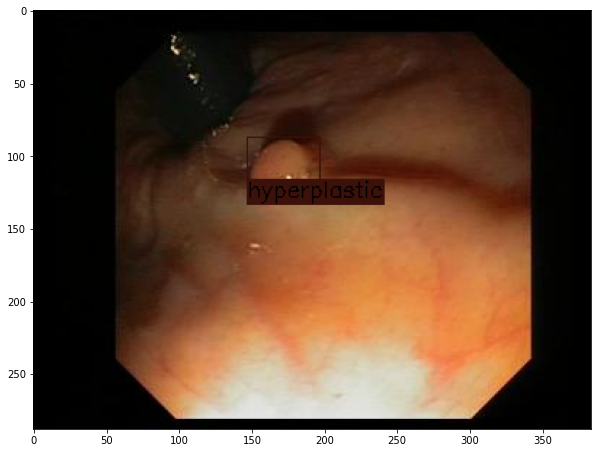


/data2/sonnh/E2EObjectDetection/PolypsSet_origin/test2019/Image/12/153.jpg
[[186. 112. 222. 143.]] ['hyperplastic']
[[ 61.10409166  84.61333671  97.10409166 115.61333671]] ['hyperplastic']
61 84 97 115 1


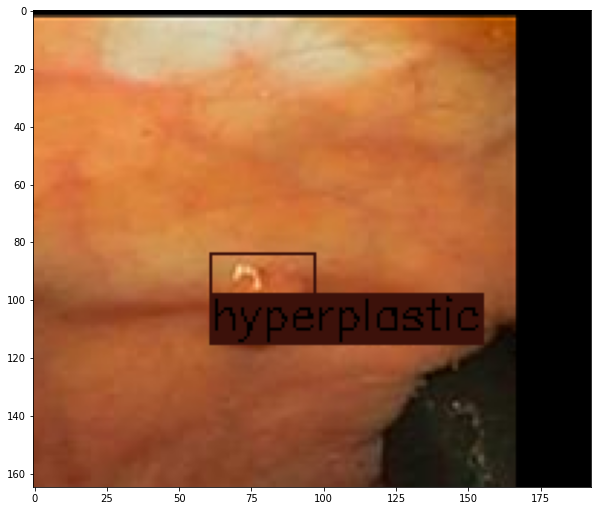


/data2/sonnh/E2EObjectDetection/PolypsSet_origin/test2019/Image/12/79.jpg
[[189. 139. 218. 163.]] ['hyperplastic']
[[242.20735242  99.77089229 271.20735242 123.77089229]] ['hyperplastic']
242 99 271 123 1


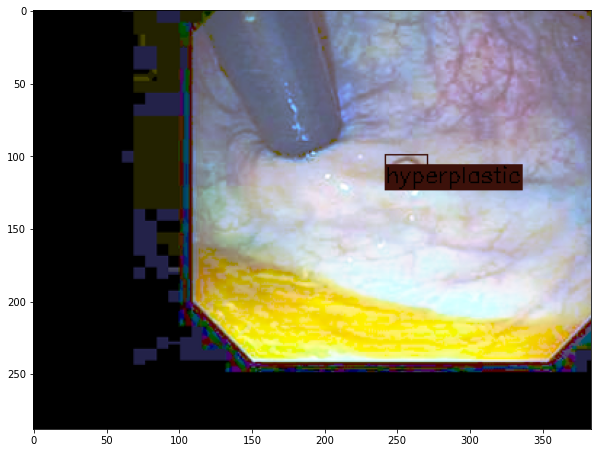


/data2/sonnh/E2EObjectDetection/PolypsSet_origin/test2019/Image/6/239.jpg
[[185. 130. 425. 360.]] ['hyperplastic']
[[ 65.98147444  86.019793   318.98147444 350.019793  ]] ['hyperplastic']
65 86 318 350 1


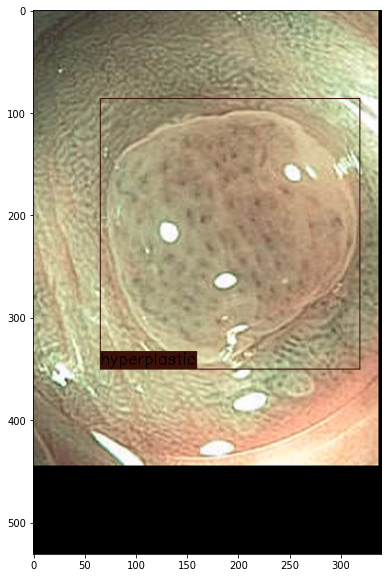


/data2/sonnh/E2EObjectDetection/PolypsSet_origin/test2019/Image/6/181.jpg
[[204.  79. 420. 291.]] ['hyperplastic']
[[215.00690533 151.30751826 431.00690533 363.30751826]] ['hyperplastic']
215 151 431 363 1


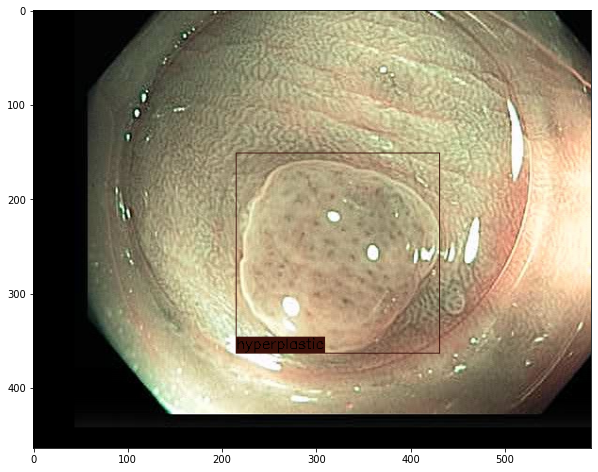

KeyboardInterrupt: Interrupted by user

In [30]:
visual_augmenter = VisualEffect(color_prob=0.5, contrast_prob=0.5,
            brightness_prob=0.5, sharpness_prob=0.5, autocontrast_prob=0.5,
            equalize_prob=0.5, solarize_prob=0.1)
misc_augmenter = MiscEffect(multi_scale_prob=0.5, rotate_prob=0.5, flip_prob=0.5, crop_prob=0.5, translate_prob=0.5) 

import json
with open('config/classes_polyp.json', 'r') as f:
    classes_dict = json.load(f)
classes = list(classes_dict.keys())
num_classes = len(classes)
colors = [np.random.randint(0, 256, 3).tolist() for i in range(num_classes)]

for d in test_data:
    fp, lp = d['im_path'], d['lb_path']
    print(fp)
    image = cv2.imread(fp)
    src_image = image.copy()

    
    lb_boxes, lb_names = parse_xml(lp)
    print(lb_boxes, lb_names)
    aug_image, aug_boxes = visual_augmenter(image), lb_boxes.copy()
    aug_image, aug_boxes = misc_augmenter(aug_image, aug_boxes)
    print(aug_boxes, lb_names)
    for box, class_name in zip(aug_boxes, lb_names):
        xmin, ymin, xmax, ymax = box[:4]
        xmin = int(xmin)
        ymin = int(ymin)
        xmax = int(xmax) 
        ymax = int(ymax) 
        class_id = classes.index(class_name)
        print(xmin, ymin, xmax, ymax, class_id)
#         try:
        color = colors[class_id]
        label = '-'.join([class_name])
        ret, baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
        aug_image = np.array(aug_image, dtype=np.uint8)
        aug_image = cv2.rectangle(aug_image, (xmin, ymin), (xmax, ymax), color, 1)
        aug_image = cv2.rectangle(aug_image, (xmin, ymax - ret[1] - baseline), (xmin + ret[0], ymax), color, -1)
        aug_image = cv2.putText(aug_image, label, (xmin, ymax - baseline), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)
#         except: 
#             print('Lỗi òi')
    
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(aug_image, cv2.COLOR_BGR2RGB))
    plt.show()
    input()

# Test polyp dataset with TFODAPI

In [ ]:
def to_xml(xml_path, imgname, boxes, labels, size):
    w, h = size
    root = ET.Element('annotations')
    filename = ET.SubElement(root, 'filename')
    filename.text = imgname
    size = ET.SubElement(root, 'size')
    width = ET.SubElement(size, 'width')
    height = ET.SubElement(size, 'height')
    width.text, height.text = str(w), str(h)
    depth = ET.SubElement(size, 'depth')
    depth.text = '3'
    for box, label in zip(boxes, labels):
        obj = ET.SubElement(root, 'object')
        name = ET.SubElement(obj, 'name')
        name.text = label
        bndbox = ET.SubElement(obj, 'bndbox')
        xmin, ymin = ET.SubElement(bndbox, 'xmin'), ET.SubElement(bndbox, 'ymin')
        xmax, ymax = ET.SubElement(bndbox, 'xmax'), ET.SubElement(bndbox, 'ymax')
        xmin.text, ymin.text, xmax.text, ymax.text = [str(b) for b in box]
    ET.ElementTree(root).write(xml_path)


In [ ]:
class Detector:
    def __init__(self):
        
#         model_path = os.path.join(os.getcwd(), "savedmodel_20220703/saved_model")
        self.model = tf.saved_model.load('/data2/sonnh/E2EObjectDetection/savedmodel_20220703/saved_model')
        self.labels = ['polyp']

    def __img2tensor__(self, image):
        image_ = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#         image_ = utils.resize_image(image_, 640)
        tensor_in = np.expand_dims(image_, 0)
        return tensor_in

    def __call__(self, img, threshold=0.5):
        tensor = self.__img2tensor__(img)
        tensor = tf.convert_to_tensor(tensor)
        s = time()
        output_dict = self.model(tensor)
        e = time()
        boxes = output_dict['detection_boxes'][0].numpy()
        scores = output_dict['detection_scores'][0].numpy()
        classes = output_dict['detection_classes'][0].numpy().astype('int32')
        h, w = img.shape[:2]
        corrected_boxes, corrected_scores, corrected_classes = [], [], []
        ymins = [] #***#
        for score, box, c in zip(scores, boxes, classes):
            if score < threshold:
                continue
            ymin, xmin, ymax, xmax = box[:4]
            xmin, xmax = int(xmin * w), int(xmax * w)
            ymin, ymax = int(ymin * h), int(ymax * h)
            corrected_boxes.append([xmin, ymin, xmax, ymax])
            corrected_classes.append(self.labels[c-1])
            corrected_scores.append(score)
            ymins.append(ymin) #***#

        # Arange box from top to bottom #
        indices = np.argsort(ymins)
        corrected_boxes = [corrected_boxes[i] for i in indices] 
        corrected_classes = [corrected_classes[i] for i in indices] 
        corrected_scores = [corrected_scores[i] for i in indices]
        #***#
        return e - s, corrected_boxes, corrected_scores, corrected_classes

detector = Detector()

In [ ]:
score_threshold = 0.3
colors = [np.random.randint(0, 256, 3).tolist() for i in range(num_classes)]
save = True
view = False
for d in test_data:
    fp, lp = d['im_path'], d['lb_path']
    print(fp)
    image = cv2.imread(fp)
    src_image = image.copy()
    src_image_2 = image.copy()
#     image = resize(512, image)
    h, w = src_image.shape[:2]
    runtime, boxes, scores, classes = detector(image, score_threshold)
    print(runtime)
    if save:
        imname = fp.split('/')[-1]
        subname = fp.split('/')[-2]
        savepath = os.path.join('/data2/sonnh/E2EObjectDetection/PolypsSet/result_test_tfodapi',subname)
        if not os.path.exists(savepath):
            os.makedirs(savepath)
        to_xml(os.path.join(savepath, imname[:-3]+'jpg'), imname, boxes, classes, (h, w))
    for box, score, class_name in zip(boxes, scores, classes):
        xmin, ymin, xmax, ymax = box
        xc, yc = (xmin + xmax) // 2, (ymin + ymax) // 2
#         print(xmin, ymin, xmax, ymax)
        score = '{:.4f}'.format(score)
        color = (0, 255, 0)
        label = '-'.join([class_name, score])
        ret, baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
        cv2.circle(src_image, (xc, yc), 5, color, -1)
        cv2.rectangle(src_image, (xmin, ymin), (xmax, ymax), color, 1)
        cv2.rectangle(src_image, (xmin, ymax - ret[1] - baseline), (xmin + ret[0], ymax), color, -1)
        cv2.putText(src_image, label, (xmin, ymax - baseline), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)
    ## Draw label 
    lb_boxes, lb_names = parse_xml(lp)
    for box, class_name in zip(lb_boxes, lb_names):
        xmin, ymin, xmax, ymax = box[:4]
        xmin = int(xmin)
        ymin = int(ymin)
        xmax = int(xmax) 
        ymax = int(ymax) 
#         print(xmin, ymin, xmax, ymax)
        color = (0, 255, 0)
        label = '-'.join([class_name])
        ret, baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
        cv2.rectangle(src_image_2, (xmin, ymin), (xmax, ymax), color, 1)
        cv2.rectangle(src_image_2, (xmin, ymax - ret[1] - baseline), (xmin + ret[0], ymax), color, -1)
        cv2.putText(src_image_2, label, (xmin, ymax - baseline), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)
    if view:
        src_image = np.concatenate([src_image, src_image_2], 1)
        plt.figure(figsize=(15, 15))
        plt.imshow(cv2.cvtColor(src_image, cv2.COLOR_BGR2RGB))
        plt.show()
        input()


## Test dummy dataset


In [ ]:
##Export to savemodel
root = 'trained_models/dummy_resnet'
json_path = os.path.join(root, 'model.json')
h5_path = os.path.join(root, 'weights_1000_0.1240.h5')

with open(json_path, 'r') as f:
    model = tf.keras.models.model_from_json(f.read())
model.load_weights(h5_path)
out = model.output
detections = decode(out[..., 4:], out[..., :2], out[..., 2:4], 10)
model_infer = tf.keras.Model(inputs=model.input, outputs=detections)
model_infer.summary()
# model_infer.save(os.path.join(root, 'savedmodel'))

# model = tf.saved_model.load(os.path.join(root, 'savedmodel'))

In [ ]:
import json

with open('config/classes_dummy.json', 'r') as f:
    classes_dict = json.load(f)
classes = list(classes_dict.keys())
num_classes = len(classes)
score_threshold = 0.001
colors = [np.random.randint(0, 256, 3).tolist() for i in range(num_classes)]
view = True
path = '/data2/sonnh/E2EObjectDetection/YoloCenter/dummy_data/train'

for name in os.listdir(path):
    if 'xml' in name:
        continue
    fp, lp = os.path.join(path, name), os.path.join(path, name[:-3] + 'xml')
    print(fp)
    image = cv2.imread(fp)
    src_image = image.copy()
    src_image_2 = image.copy()
#     image = resize(512, image)
    image = cv2.resize(image, (512, 512))
    image = preprocess_image(image)
    inputs = np.expand_dims(image, axis=0)
    # run network
    start = time()
#     detections = model_infer(inputs, training=False)[0].numpy()
    out = model(inputs, training=False).numpy()
    detections = decode(out[..., 4:], out[..., :2], out[..., 2:4], 10)[0]
    print(detections)
    print(time() - start)
    h, w = src_image.shape[:2]
    boxes, scores, class_ids = detections[..., :4], detections[..., 4], detections[..., 5]
#     boxes = boxes * 512
#     boxes = rescale_boxes(512, (w, h), boxes)
    for box, score, class_id in zip(boxes, scores, class_ids):
        if score < score_threshold:
            continue
        xmin, ymin, xmax, ymax = box
        xmin, ymin, xmax, ymax = int(xmin*w), int(ymin*h), int(xmax*w), int(ymax*h)

        xc, yc = (xmin + xmax) // 2, (ymin + ymax) // 2
        print(xmin, ymin, xmax, ymax)
        score = '{:.4f}'.format(score)
        class_id = int(class_id)
        color = colors[class_id]
        class_name = classes[class_id]
        label = '-'.join([class_name, score])
        ret, baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
        cv2.circle(src_image, (xc, yc), 5, color, -1)
        cv2.rectangle(src_image, (xmin, ymin), (xmax, ymax), color, 1)
        cv2.rectangle(src_image, (xmin, ymax - ret[1] - baseline), (xmin + ret[0], ymax), color, -1)
        cv2.putText(src_image, label, (xmin, ymax - baseline), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)
    ## Draw label 
    lb_boxes, lb_names = parse_xml(lp)
    for box, class_name in zip(lb_boxes, lb_names):
        xmin, ymin, xmax, ymax = box[:4]
        xmin = int(xmin)
        ymin = int(ymin)
        xmax = int(xmax) 
        ymax = int(ymax) 
#         print(xmin, ymin, xmax, ymax)
        class_id = classes.index(class_name)
        color = colors[class_id]
        label = '-'.join([class_name])
        ret, baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
        cv2.rectangle(src_image_2, (xmin, ymin), (xmax, ymax), color, 1)
        cv2.rectangle(src_image_2, (xmin, ymax - ret[1] - baseline), (xmin + ret[0], ymax), color, -1)
        cv2.putText(src_image_2, label, (xmin, ymax - baseline), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)
    
    heatmap = inv_resize((h, w), cv2.resize(viz_heatmap(out[..., 4:][0]), (512, 512)))
    src_image_2 = cv2.addWeighted(src_image_2, 0.7, heatmap, 0.3, 0)
    src_image = np.concatenate([src_image, src_image_2], 1)
    plt.figure(figsize=(15, 15))
    plt.imshow(cv2.cvtColor(src_image, cv2.COLOR_BGR2RGB))
#     plt.figure(figsize=(10,10))
#     plt.imshow(heatmap)
    plt.show()
    input()
